# Introduction: Tuning Automated Feature Engineering

In this notebook we will expand upon the basic automated feature engineering done in the introductory notebook. We will explore a few different options for improving the set of features, most notably, creating time variables from the relative time information in the data. We can also explore creating seed features and "interesting variables". Reading through the discussion around this competition and working through some other's kernels, intricate feature engineering is a must. Using the default feature transforms did improve our score, but to do better we will need some more advanced methods. 

Several of the methods we will look at in this notebook are:

* Properly representing variable types
* Creating time variables
* Using interesting values
* Seed features
* Custom primitives

This is meant more as an exploration of the capabilities of featuretools than a complete implementation. I'm still working on figuring out the most useful features to build by reading through other kernels, finding features, and figuring out how to recreate those in featuretools. 

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings 
warnings.filterwarnings('ignore')

### Read in Data and Create Smaller Datasets

We will limit the data to 1000 rows because automated feature engineering is computationally intensive work. Later we can refactor this code into functions and put it in a script to run on a more powerful machine. 

In [2]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# This allows us to actually see the results in a reasonable amount of time! 
app_train = pd.read_csv('../input/application_train.csv').sort_values('SK_ID_CURR').reset_index().loc[:500, :].drop(columns = ['index'])
app_test = pd.read_csv('../input/application_test.csv').sort_values('SK_ID_CURR').reset_index().loc[:500, :].drop(columns = ['index'])
bureau = pd.read_csv('../input/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index().loc[:1000, :].drop(columns = ['index'])
bureau_balance = pd.read_csv('../input/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index().loc[:1000, :].drop(columns = ['index'])
cash = pd.read_csv('../input/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
credit = pd.read_csv('../input/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
previous = pd.read_csv('../input/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
installments = pd.read_csv('../input/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])

In [3]:
# Join the appliation dataframes together
app_test['set'] = 'test'
app_test['TARGET'] = -999
app_train['set'] = 'train'

# Append the dataframes (this is a row bind in R)
app = app_train.append(app_test, ignore_index = True)

## Properly Representing Variables Types

There are a number of columns in the `app` dataframe that are represented as integers but are really Boolean variables. These represent flags that can only take on a limited number of values (usually 2). To tell featuretools to treat these as Boolean variables, we need to pass in the correct datatype. After going through the column definitions, I identified all of the categorical variables. To pass these to featuretools, we need to make a dictionary mapping {`categorical_variable`: `ft.variable_types.Boolean`}. 

In [4]:
app_types = {}

# Iterate through the columns and record the categorical columns
for col in app:
    # If column is a number with only two values, encode it as a Boolean
    if (app[col].dtype != 'object') and (len(app[col].unique()) <= 2):
        app_types[col] = ft.variable_types.Boolean

print('Number of categorical variables: ', len(app_types))

Number of categorical variables:  32


There are also two ordinal variables in the `app` data: the rating of the region with and without the city. 

In [5]:
# Record ordinal variables
app_types['REGION_RATING_CLIENT'] = ft.variable_types.Ordinal
app_types['REGION_RATING_CLIENT_W_CITY'] = ft.variable_types.Ordinal

In [6]:
# Record boolean variables in the previous data
previous_types= {'NFLAG_LAST_APPL_IN_DAY': ft.variable_types.Boolean,
                 'NFLAG_INSURED_ON_APPROVAL': ft.variable_types.Boolean}

# Time Variable

Time can be a crucial factor in many datasets. Behavior changes over time, and we might want to make features to reflect this. For example, a client might be taking out larger and larger loans over time which could be an indicator that they are about to default. 

There are no explicit datetimes in the data, but we can create our own using the provided day and month offsets. For example, in `bureau`, the `DAYS_CREDIT` column represents the "How many days before current application did client apply for Credit Bureau credit". (credit bureau refers to any other credit organization besides Home Credit). Although we do not know the actual application date, if we assume a starting application date that is the same for all clients, then we can convert the `MONTHS_BALANCE` into a datetime. We won't use the weekday, month, or hour of this datetime because only the relative times are important.

First we can establish an arbitrary date and then convert the time offset in months into a Pandas `timedelta` object. 

In [7]:
# Establish a starting date for all applications at Home Credit
start_date = pd.Timestamp("2016-01-01")
start_date

Timestamp('2016-01-01 00:00:00')

In [8]:
# Convert to timedelta in days
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    bureau[col] = pd.to_timedelta(bureau[col], 'D')
    
bureau[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].head()

,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE
0,-857 days,-492 days,-553 days,-155 days
1,-909 days,-179 days,-877 days,-155 days
2,-879 days,-514 days,-544 days,-155 days
3,-1572 days,-1329 days,-1328 days,-155 days
4,-559 days,902 days,NaT,-6 days


Converting to timedelta objects allows for efficient vectorized operations of entire columns. 

These four columns represent different offsets:

* `DAYS_CREDIT`: Number of days before current application at Home Credit client applied for loan at other financial institution. We will call this the application date, `bureau_credit_application_date`
* `DAYS_CREDIT_ENDDATE`: Number of days of credit remaining at time of client's application at Home Credit. We will call this the ending date, `bureau_credit_end_date`
* `DAYS_ENDDATE_FACT`: For closed credits, the number of days before current application at Home Credit that credit at other financial institution ended. We will call this the closing date, `bureau_credit_close_date`. 
* `DAYS_CREDIT_UPDATE`: Number of days before current application at Home Credit that the most recent information about the previous credit arrived. We will call this the update date, `bureau_credit_update_date`. 

If we were doing manual feature engineering, we might want to create new columns such as by subtracting `DAYS_CREDIT_ENDDATE` from `DAYS_CREDIT` to get the planned length of the loan in days, or subtracting `DAYS_CREDIT_ENDDATE` from `DAYS_ENDDATE_FACT` to find the number of days the client paid off the loan early. However, in this notebook we will not make any features by hand, but rather let featuretools develop any potentially useful features for us.

To make date columns, we simply add the offset to the start date. 

In [9]:
# Create the date columns
bureau['bureau_credit_application_date'] = start_date + bureau['DAYS_CREDIT']
bureau['bureau_credit_end_date'] = start_date + bureau['DAYS_CREDIT_ENDDATE']
bureau['bureau_credit_close_date'] = start_date + bureau['DAYS_ENDDATE_FACT']
bureau['bureau_credit_update_date'] = start_date + bureau['DAYS_CREDIT_UPDATE']

### Plot for a sanity check

To make sure the conversion went as planned, let's make two plots: the first will be the difference beween `bureau_credit_applicate_date` and `bureau_credit_end_date`. This represents the planned length of the loan in days.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up default plot styles
plt.rcParams['font.size'] = 26
plt.style.use('fivethirtyeight')

D:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


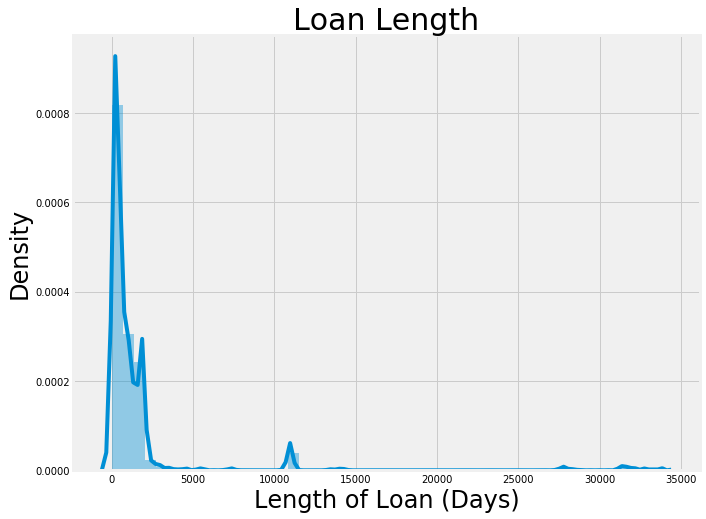

In [11]:
plt.figure(figsize = (10, 8))
sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days);
plt.xlabel('Length of Loan (Days)', size = 24); plt.ylabel('Density', size = 24); plt.title('Loan Length', size = 30);

It looks as if there are a number of loans that are unreasonably long. Reading through the discussions, other data scientists had noticed this as well. At this point, we will just leave in the outliers. 

Again we see a number of suspicious loans that were paid off tens of thousands of days early. We will leave this, but might want to revisit later. 

In [13]:
# Drop the time offset columns
bureau = bureau.drop(columns = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'])

#### Bureau Balance

The bureau balance dataframe has a `MONTHS_BALANCE` column that we can use as a months offset. 

In [14]:
# Convert to timedelta
bureau_balance['MONTHS_BALANCE'] = pd.to_timedelta(bureau_balance['MONTHS_BALANCE'], 'M')

# Make a date column
bureau_balance['bureau_balance_date'] = start_date + bureau_balance['MONTHS_BALANCE']
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,bureau_balance_date
0,5001709,-214 days +22:36:18,C,2015-06-01 22:36:18
1,5001709,-92 days +16:32:42,C,2015-10-01 16:32:42
2,5001709,-122 days +06:03:36,C,2015-09-01 06:03:36
3,5001709,-153 days +19:34:30,C,2015-08-01 19:34:30
4,5001709,-183 days +09:05:24,C,2015-07-02 09:05:24


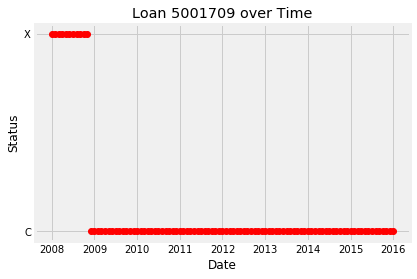

In [15]:
# Select one loan and plot
example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]
plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro');
plt.title('Loan 5001709 over Time'); plt.xlabel('Date'); plt.ylabel('Status');

In [17]:
bureau_balance = bureau_balance.drop(columns = ['MONTHS_BALANCE'])

### Previous Applications

The `previous` dataframe holds previous applications at Home Credit. There are a number of time offset columns in this dataset:

* `DAYS_DECISION`: number of days before current application at Home Credit that decision was made about previous application
* `DAYS_FIRST_DRAWING`: number of days before current application at Home Credit that first disbursement was made
* `DAYS_FIRST_DUE`: number of days before current application at Home Credit that first due was suppoed to be
* `DAYS_LAST_DUE_1ST_VERSION`: number of days before current application at Home Credit that first was??
* `DAYS_LAST_DUE`: number of days before current application at Home Credit of last due date of previous application
* `DAYS_TERMINATION`: number of days before current application at Home Credit of expected termination

Let's convert all these into timedeltas in a loop and then make time columns.

In [18]:
# Convert to timedeltas in days
for col in ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    try:
        previous[col] = previous[col].replace({365243: pd.NaT})
        previous[col] = pd.to_timedelta(previous[col], 'D')
    except Exception as e:
        print(col, e)

In [19]:
# Make date columns
previous['previous_decision_date'] = start_date + previous['DAYS_DECISION']
previous['previous_drawing_date'] = start_date + previous['DAYS_FIRST_DRAWING']
previous['previous_first_due_date'] = start_date + previous['DAYS_FIRST_DUE']
previous['previous_last_duefirst_date'] = start_date + previous['DAYS_LAST_DUE_1ST_VERSION']
previous['previous_last_due_date'] = start_date + previous['DAYS_LAST_DUE']
previous['previous_termination_date'] = start_date + previous['DAYS_TERMINATION']

# Drop the time offset columns
previous = previous.drop(columns = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'])

# Plot one client as an example
plt.figure(figsize = (8, 6))
example_client = previous[previous['SK_ID_CURR'] == 100008]
plt.plot(example_client['previous_decision_date'], example_client['AMT_CREDIT'], 'ro')
plt.title('Client 100003 Previous Loan Amounts'); plt.xlabel('Date'); plt.ylabel('Credit Amount');

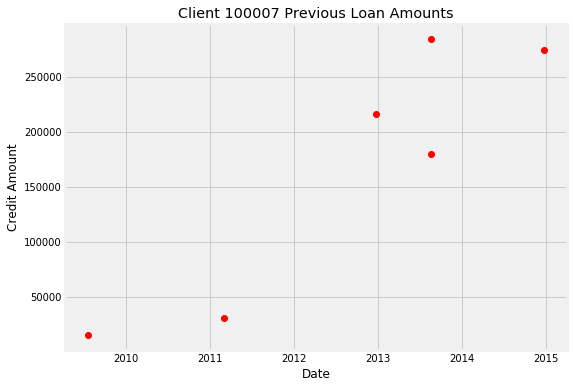

In [22]:
plt.figure(figsize = (8, 6))
example_client = previous[previous['SK_ID_CURR'] == 100007]
plt.plot(example_client['previous_decision_date'], example_client['AMT_CREDIT'], 'ro')
plt.title('Client 100007 Previous Loan Amounts'); plt.xlabel('Date'); plt.ylabel('Credit Amount');

#### Previous Credit and Cash

The `credit_card_balance` and `POS_CASH_balance` each have a `MONTHS_BALANCE` column with the month offset. This is the number of months before the current application at Home Credit of the previous application record. These will be converted to timedeltas and then dates can be added.

In [23]:
# Convert to timedelta objects
credit['MONTHS_BALANCE'] = pd.to_timedelta(credit['MONTHS_BALANCE'], 'M')
cash['MONTHS_BALANCE'] = pd.to_timedelta(cash['MONTHS_BALANCE'], 'M')

# Make a date column
credit['credit_balance_date'] = start_date + credit['MONTHS_BALANCE']
credit = credit.drop(columns = ['MONTHS_BALANCE'])

# Make a date column
cash['cash_balance_date'] = start_date + cash['MONTHS_BALANCE']
cash = cash.drop(columns = ['MONTHS_BALANCE'])

# Select on loan and plot
example_credit = cash[cash['SK_ID_PREV'] == 1369693]

plt.plot(example_credit['cash_balance_date'], example_credit['NAME_CONTRACT_STATUS'], 'ro');
plt.title('Loan 1369693 over Time'); plt.xlabel('Date'); plt.ylabel('Contract Status');

#### Installments Payments 

The `installments_payments` data contains information on each payment made on the previous loans at Home Credit. It has two date offset columns:

* `DAYS_INSTALMENT`: number of days before current application at Home Credit that previous installment was supposed to be paid
* `DAYS_ENTRY_PAYMENT`: number of days before current application at Home Credit that previous installment was actually paid

By now the process should be familiar: convert to timedeltas and then make time columns. 

In [25]:
# Conver to time delta object
installments['DAYS_INSTALMENT'] = pd.to_timedelta(installments['DAYS_INSTALMENT'], 'D')
installments['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(installments['DAYS_ENTRY_PAYMENT'], 'D')

# Create time column and drop
installments['installments_due_date'] = start_date + installments['DAYS_INSTALMENT']
installments = installments.drop(columns = ['DAYS_INSTALMENT'])

installments['installments_paid_date'] = start_date + installments['DAYS_ENTRY_PAYMENT']
installments = installments.drop(columns = ['DAYS_ENTRY_PAYMENT'])

# Select one loan and plot
example_credit = installments[installments['SK_ID_PREV'] == 1369693]
plt.plot((example_credit['installments_due_date'] - example_credit['installments_paid_date']).dt.days, example_credit['AMT_INSTALMENT'], 'ro');
plt.title('Loan 1369693'); plt.xlabel('Days Paid Early'); plt.ylabel('Installment Amount');

# Applying Featuretools

We can now start making features using the time columns. We will create an entityset named clients much as before, but now we have time variables that we can use. 

In [27]:
# Make an entityset
es = ft.EntitySet(id = 'clients')

### Entities

When creating the entities, we specify the index, the time index (if present), and the variable types (if they need to be specified). 

In [28]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, 
                              index = 'SK_ID_CURR', variable_types = app_types)

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, 
                              index = 'SK_ID_BUREAU', time_index='bureau_credit_application_date')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, 
                              index = 'SK_ID_PREV', time_index = 'previous_decision_date',
                              variable_types = previous_types)

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bb_index',
                              time_index = 'bureau_balance_date')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index',
                              time_index = 'cash_balance_date')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index',
                              time_index = 'installments_paid_date')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index',
                              time_index = 'credit_balance_date')

### Relationships

Not surprisingly, the relationships between tables has not changed since the previous implementation. 

In [29]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

## Time Features

Let's look at some of the time features we can make from the new time variables. Because there times are relative, we are only interested in values that show change over time, such as trend or cumulative max.

In [31]:
time_features, time_feature_names = ft.dfs(entityset = es, target_entity = 'app', 
                            trans_primitives = ['cum_sum'], max_depth = 2,
                            agg_primitives = ['trend'] ,
                            features_only = False, verbose = True)

Built 220 features
Elapsed: 00:28 | Remaining: 00:00 | Progress: 100%|██████████████████████| Calculated: 11/11 chunks


In [32]:
time_features.iloc[:, -10:].head()

,"TREND(previous.CUM_SUM(RATE_INTEREST_PRIMARY by SK_ID_CURR), previous_decision_date)","TREND(previous.TREND(credit.AMT_DRAWINGS_CURRENT, credit_balance_date), previous_decision_date)","TREND(bureau.CUM_SUM(AMT_CREDIT_SUM_DEBT by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(CNT_CREDIT_PROLONG by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(CREDIT_DAY_OVERDUE by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(AMT_CREDIT_SUM by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(AMT_ANNUITY by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(AMT_CREDIT_MAX_OVERDUE by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(AMT_CREDIT_SUM_OVERDUE by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(AMT_CREDIT_SUM_LIMIT by SK_ID_CURR), bureau_credit_application_date)"
SK_ID_CURR,,,,,,,,,,
100001,NaN,NaN,362.416607,0.0,0.0,925.223442,16.419025,NaN,0.0,0.000000
100002,NaN,NaN,161.245120,0.0,0.0,657.718776,0.000000,6.565831,0.0,23.113250
100003,NaN,NaN,0.000000,0.0,0.0,354.477112,NaN,0.000000,0.0,259.225363
100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,NaN,NaN,1941.526227,0.0,0.0,2041.523367,10.408240,NaN,0.0,0.000000


Let's visualize one of these new variables. We can look at the trend in credit size over time. A positive value indicates that the loan size for the client is increasing over time. 

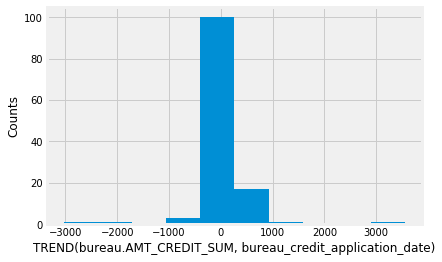

In [33]:
plt.hist(time_features['TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'].dropna());
plt.xlabel('TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'); plt.ylabel('Counts');

In [34]:
time_feature_names[-10:]

[<Feature: TREND(previous.CUM_SUM(RATE_INTEREST_PRIMARY by SK_ID_CURR), previous_decision_date)>,
 <Feature: TREND(previous.TREND(credit.AMT_DRAWINGS_CURRENT, credit_balance_date), previous_decision_date)>,
 <Feature: TREND(bureau.CUM_SUM(AMT_CREDIT_SUM_DEBT by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(CNT_CREDIT_PROLONG by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(CREDIT_DAY_OVERDUE by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(AMT_CREDIT_SUM by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(AMT_ANNUITY by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(AMT_CREDIT_MAX_OVERDUE by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(AMT_CREDIT_SUM_OVERDUE by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(AMT_CREDIT_SUM_LIMIT by SK_ID_CURR), bureau_credit_appli

# Interesting Values

Another aspect of featuretools we can use is "interesting values." These calculate new features conditioned on values of existing features. For example, we can create new features that are conditioned on the value of `NAME_CONTRACT_STATUS` in the previous dataframe. This represents the condition of a previous loan application. 

In [35]:
previous['NAME_CONTRACT_STATUS'].value_counts()

Approved        594
Refused         206
Canceled        186
Unused offer     15
Name: NAME_CONTRACT_STATUS, dtype: int64

In [36]:
# Assign interesting values
es['previous']['NAME_CONTRACT_STATUS'].interesting_values = ['Approved', 'Refused', 'Canceled']

# Calculate the features with intereseting values
interesting_features, interesting_feature_names = ft.dfs(entityset=es, target_entity='app', max_depth = 1, 
                                                         agg_primitives=['mean'], 
                                                         where_primitives = ['mean'], 
                                                         trans_primitives=[], features_only = False, verbose = True)

Built 174 features
Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████████████████| Calculated: 11/11 chunks


In [37]:
interesting_features.iloc[:, -6:, ].head()

,MEAN(previous.SELLERPLACE_AREA WHERE NAME_CONTRACT_STATUS = Approved),MEAN(previous.SELLERPLACE_AREA WHERE NAME_CONTRACT_STATUS = Refused),MEAN(previous.SELLERPLACE_AREA WHERE NAME_CONTRACT_STATUS = Canceled),MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Approved),MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Refused),MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Canceled)
SK_ID_CURR,,,,,,
100001,23.0,NaN,NaN,8.0,NaN,NaN
100002,500.0,NaN,NaN,24.0,NaN,NaN
100003,533.0,NaN,NaN,10.0,NaN,NaN
100004,30.0,NaN,NaN,4.0,NaN,NaN
100005,37.0,NaN,-1.0,12.0,NaN,NaN


One of the features is `MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Approved)`. This shows the average number of payments on previous loans where the previous loan was approved. We can compare the distribution of this feature to the `MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Canceled)` to see how these loans differ.

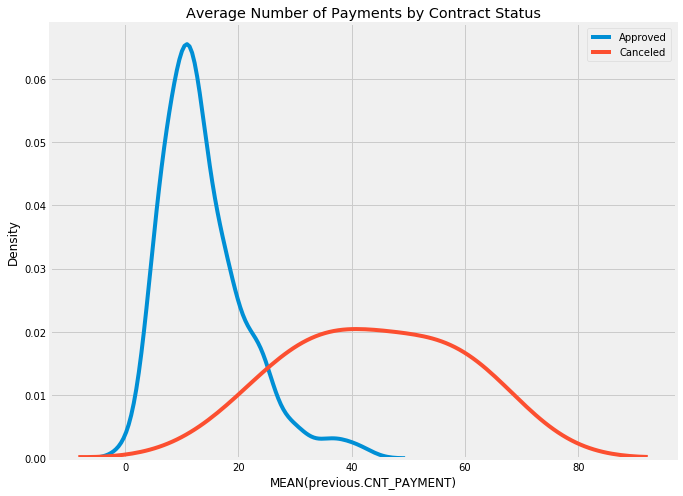

In [38]:
plt.figure(figsize = (10, 8))
sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Approved)'].dropna(), label = 'Approved')
sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Canceled)'].dropna(), label = 'Canceled')
plt.xlabel('MEAN(previous.CNT_PAYMENT)'); plt.ylabel('Density'); plt.title('Average Number of Payments by Contract Status');

# Seed Features

An additional extension to the default aggregations and transformations is to use [seed features](https://docs.featuretools.com/automated_feature_engineering/dfs_usage_tips.html#specifying-list-of-aggregation-functions). These are user defined features that we provide to deep feature synthesis that can then be built on top of where possible. 

For example, we could create a feature that determines if a loan payment was late. 

In [39]:
es['installments']

Entity: installments
  Variables:
    SK_ID_PREV (dtype: id)
    SK_ID_CURR (dtype: numeric)
    NUM_INSTALMENT_VERSION (dtype: numeric)
    NUM_INSTALMENT_NUMBER (dtype: numeric)
    AMT_INSTALMENT (dtype: numeric)
    AMT_PAYMENT (dtype: numeric)
    installments_due_date (dtype: datetime)
    installments_paid_date (dtype: datetime_time_index)
    installments_index (dtype: index)
  Shape:
    (Rows: 1001, Columns: 9)

In [40]:
# Late Payment seed feature
late_payment = ft.Feature(es['installments']['installments_due_date']) < ft.Feature(es['installments']['installments_paid_date'])

# Rename the feature
late_payment = late_payment.rename("late_payment")

# DFS with seed features
seed_features, seed_feature_names = ft.dfs(entityset = es,
                                           target_entity = 'app',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [], 
                                           seed_features = [late_payment],
                                           features_only = False, verbose = True)

Built 205 features
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████████████████| Calculated: 11/11 chunks


In [41]:
seed_features.iloc[:, -2:].head(10)

,PERCENT_TRUE(installments.late_payment),MEAN(previous.PERCENT_TRUE(installments.late_payment))
SK_ID_CURR,,
100001,0.000000,0.000000
100002,0.000000,0.000000
100003,0.000000,0.000000
100004,0.000000,0.000000
100005,0.111111,0.111111


No handles with labels found to put in legend.


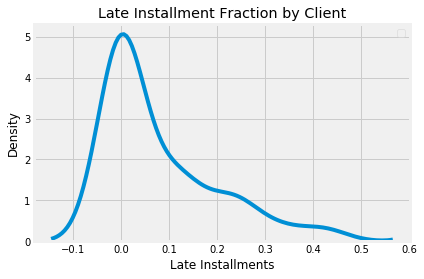

In [42]:
sns.kdeplot(seed_features['PERCENT_TRUE(installments.late_payment)'].dropna(), label = '')
plt.xlabel('Late Installments'); plt.ylabel('Density'); plt.title('Late Installment Fraction by Client');

Another seed feature we can use is whether or not a previous loan at another institution was past due. 

In [43]:
# Create a feed representing whether the loan is past due
past_due = ft.Feature(es['bureau_balance']['STATUS']) == 'X'
past_due = past_due.rename("past_due")

# DFS with specified seed feature
seed_features, seed_feature_names = ft.dfs(entityset = es,
                                           target_entity = 'app',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [], 
                                           seed_features = [past_due],
                                           features_only = False, verbose = True)

Built 205 features
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████████████████| Calculated: 11/11 chunks


# Create Custom Feature Primitives

Finally, if we are not satisfied with the existing primitives in featuretools, we can write our own. This is an extremely powerful method that lets us expand the capabilities of featuretools. 

As an example, we will make a feature that finds the fraction of all observations of the most common observation in a categorical feature. For instance, if a client has had 5 total status observations and 4 of those were 'C', then the Mode will be 'C' and the normalized mode count will be 0.8. 

In [44]:
from featuretools.variable_types import (
    Boolean,
    DatetimeTimeIndex,
    Discrete,
    Index,
    Numeric,
    Variable
)

from featuretools.primitives import AggregationPrimitive, make_agg_primitive
from collections import Counter

# Building on the Mode Aggregation Primitive
class NormalizedModeCount(AggregationPrimitive):
    """Finds the fraction of total observations of the most common observation in a categorical variable."""
    name = "normalizedmodecount"
    input_types = [Discrete]
    return_type = Numeric

    def get_function(self):
        def pd_normalizedmodecount(x):
            if x.mode().shape[0] == 0:
                return np.nan
            
            # Count occurence of each value
            counts = dict(Counter(x.values))
            # Find the mode
            mode = x.mode().iloc[0]
            # Divide the occurences of mode by the total occurrences
            return counts[mode] / np.sum(list(counts.values()))
        return pd_normalizedmodecount

In [45]:
custom_feature, custom_feature_names = ft.dfs(entityset = es,
                                              target_entity = 'app',
                                              agg_primitives = ['mode', NormalizedModeCount],
                                              trans_primitives = [],
                                              features_only = False, verbose = True)

Built 172 features
Elapsed: 00:04 | Remaining: 00:00 | Progress: 100%|██████████████████████| Calculated: 11/11 chunks


In [47]:
custom_feature.loc[:, ['MODE(previous.NAME_CONTRACT_STATUS)', 'NORMALIZEDMODECOUNT(previous.NAME_CONTRACT_STATUS)']].dropna().head(10)

,MODE(previous.NAME_CONTRACT_STATUS),NORMALIZEDMODECOUNT(previous.NAME_CONTRACT_STATUS)
SK_ID_CURR,,
100001,Approved,1.000000
100002,Approved,1.000000
100003,Approved,1.000000
100004,Approved,1.000000
100005,Approved,0.500000
100006,Approved,0.555556
100007,Approved,1.000000
100008,Approved,0.800000
100009,Approved,1.000000


# Putting it all Together

Finally, we can run deep feature synthesis with the time variables, with the correct specified categorical variables, with the interesting features, with the seed features, and with the custom feature. To actually run this on the entire dataset, we can take the code here, put it in a script, and then use more computational resources. 

In [48]:
# Run and create the features
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app',
                                       agg_primitives = ['mean', 'max', 'min', 'trend', 'last', 'mode', 'count', 'sum', 'percent_true', NormalizedModeCount],
                                       trans_primitives = ['diff', 'cum_sum', 'cum_mean', 'percentile'], 
                                       where_primitives = ['mean', 'sum'],
                                       seed_features = [late_payment, past_due],
                                       max_depth = 2, features_only = False, verbose = True)

Built 4487 features
Elapsed: 07:34 | Remaining: 00:00 | Progress: 100%|██████████████████████| Calculated: 11/11 chunks


In [49]:
import random
random.sample(feature_names, 10)

[<Feature: MAX(previous.DIFF(RATE_DOWN_PAYMENT by SK_ID_CURR))>,
 <Feature: MEAN(previous.MIN(credit.CNT_DRAWINGS_OTHER_CURRENT) WHERE NAME_CONTRACT_STATUS = Refused)>,
 <Feature: MODE(previous.NAME_PAYMENT_TYPE)>,
 <Feature: SUM(previous.MEAN(cash.CNT_INSTALMENT) WHERE NAME_CONTRACT_STATUS = Canceled)>,
 <Feature: MAX(previous.SUM(credit.AMT_CREDIT_LIMIT_ACTUAL))>,
 <Feature: SUM(previous.AMT_DOWN_PAYMENT WHERE NAME_CONTRACT_STATUS = Refused)>,
 <Feature: SUM(previous.LAST(credit.AMT_PAYMENT_TOTAL_CURRENT) WHERE NAME_CONTRACT_STATUS = Canceled)>,
 <Feature: MEAN(previous.DIFF(RATE_DOWN_PAYMENT by SK_ID_CURR) WHERE NAME_CONTRACT_STATUS = Canceled)>,
 <Feature: YEARS_BUILD_MODE>,
 <Feature: PERCENTILE(BASEMENTAREA_MEDI)>]

# Conclusions 

In this notebook we look at some of the more advanced functionality in featuretools. We can use these methods to encode domain knowledge and try to extract as much useful information from the given data as possible. The next step is to implement this code in a script on a high-powered computer. Then we can use the features for modeling, determine which are the most important, perform feature selection, and maybe perform feature synthesis with a new set of of primitives, seed features, and interesting features. As with many aspects of machine learning, feature creation is largely an empirical and iterative procedure. 